## Take gridded SOCAT fCO2 and convert to pCO2 
### using atmospheric pressure and sea surface temperature

In [42]:
import pandas as pd
import xarray as xr
import numpy as np
import numpy.ma as ma
%matplotlib inline
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
import scipy
import sklearn.linear_model 
import pickle

In [2]:
%run fco2_to_pco2.ipynb

In [3]:
socat = xr.open_dataset('/data/artemis/observations/SOCAT/originals/SOCATv2021_tracks_gridded_monthly.nc')

In [27]:
fco2 = socat.fco2_ave_weighted
fco2_unweight = socat.fco2_ave_unwtd
time = fco2.tmnth
ylat = fco2.ylat
xlon = fco2.xlon

Need sea level pressure and sea surface temperature to convert to pCO2

In [5]:
sst = socat.sst_ave_weighted
sst_unweight = socat.sst_ave_unwtd

In [31]:
era5 = xr.open_dataset('/data/artemis/observations/ERA5_MSLP/ERA5_MSLP_1x1_1979-2021.nc')

In [33]:
print(era5.mslp)

<xarray.DataArray 'mslp' (time: 516, lat: 180, lon: 360)>
[33436800 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    units:    hPa


In [34]:
mslp = era5.mslp
long = mslp.lon
lat = mslp.lat
etime = era5.time

In [11]:
print(np.shape(mslp))

(516, 180, 360)


In [19]:
# SOCAT Time Begins 1970-Jan #
# ERA5 starts 1979-Jan #
# Use SOCAT time starting at index 108 (Start of 1979)
# Go through end of 2020
##############################
print(time[611])
print(time[108])

<xarray.DataArray 'tmnth' ()>
array('2020-12-16T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    tmnth    datetime64[ns] 2020-12-16T12:00:00
Attributes:
    axis:           T
    bounds:         tmnth_bnds
    time_origin:    01-JAN-1970
    standard_name:  time
<xarray.DataArray 'tmnth' ()>
array('1979-01-16T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    tmnth    datetime64[ns] 1979-01-16T12:00:00
Attributes:
    axis:           T
    bounds:         tmnth_bnds
    time_origin:    01-JAN-1970
    standard_name:  time


In [37]:
pco2 = fCO2_to_pCO2(fco2[108:612,:,:], sst[108:612,:,:], mslp[0:504,:,:], tempEQ_C=None)

/home/vbennington/LDEO_HPD/data_processing/check_units.py:256: RuntimeWarning: invalid value encountered in less
  outside = (arr < lims[0]) | (arr > lims[1])
/home/vbennington/LDEO_HPD/data_processing/check_units.py:256: RuntimeWarning: invalid value encountered in greater
  outside = (arr < lims[0]) | (arr > lims[1])


In [39]:
pco2_unwt = fCO2_to_pCO2(fco2_unweight[108:612,:,:], sst_unweight[108:612,:,:], mslp[0:504,:,:], tempEQ_C=None)

/home/vbennington/LDEO_HPD/data_processing/check_units.py:256: RuntimeWarning: invalid value encountered in less
  outside = (arr < lims[0]) | (arr > lims[1])
/home/vbennington/LDEO_HPD/data_processing/check_units.py:256: RuntimeWarning: invalid value encountered in greater
  outside = (arr < lims[0]) | (arr > lims[1])


## Examine whether minimum and maximum values occur
### Likely coastal

/home/vbennington/.conda/envs/dev2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: All-NaN slice encountered
  


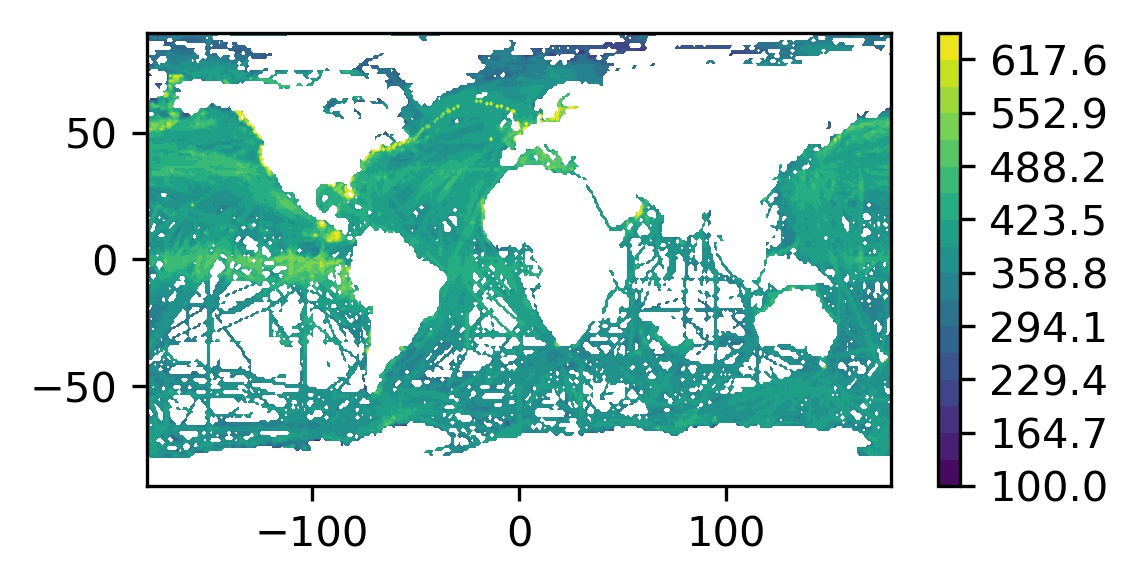

In [63]:
fig = plt.figure(figsize=(4,2))
plt.contourf(xlon,ylat,np.nanmax(pco2,axis=0),levels=np.linspace(100,650,18))
plt.colorbar()

/home/vbennington/.conda/envs/dev2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: All-NaN slice encountered
  


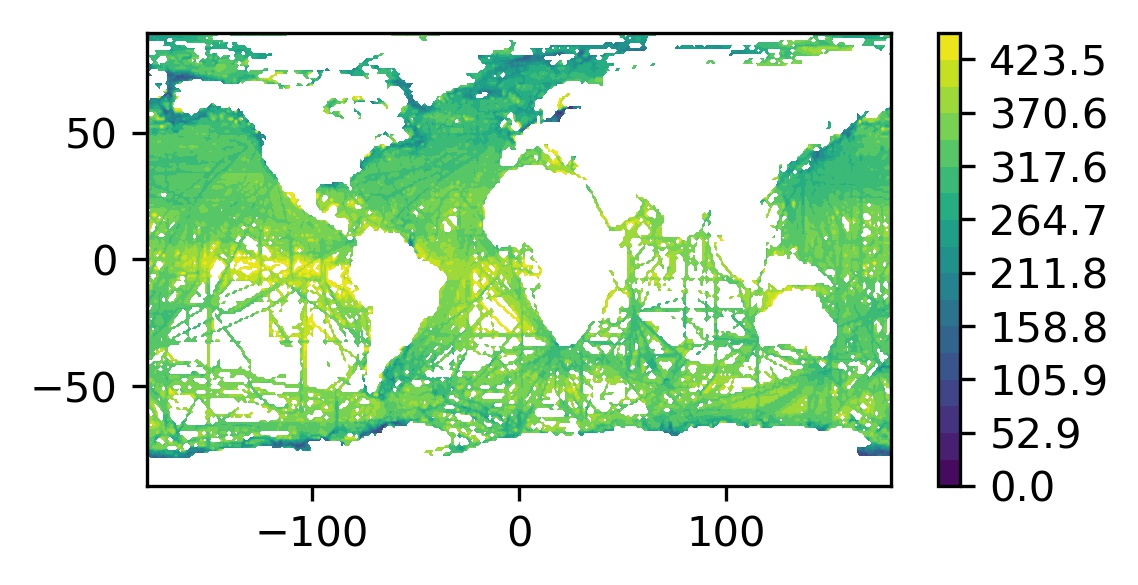

In [62]:
fig = plt.figure(figsize=(4,2))
plt.contourf(xlon,ylat,np.nanmin(pco2,axis=0),levels=np.linspace(0,450,18))
plt.colorbar()

### Keep 200-650 ppm

In [65]:
pco2 = np.where((pco2>200)&(pco2<650),pco2,np.nan)

/home/vbennington/.conda/envs/dev2/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/home/vbennington/.conda/envs/dev2/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


/home/vbennington/.conda/envs/dev2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: All-NaN slice encountered
  


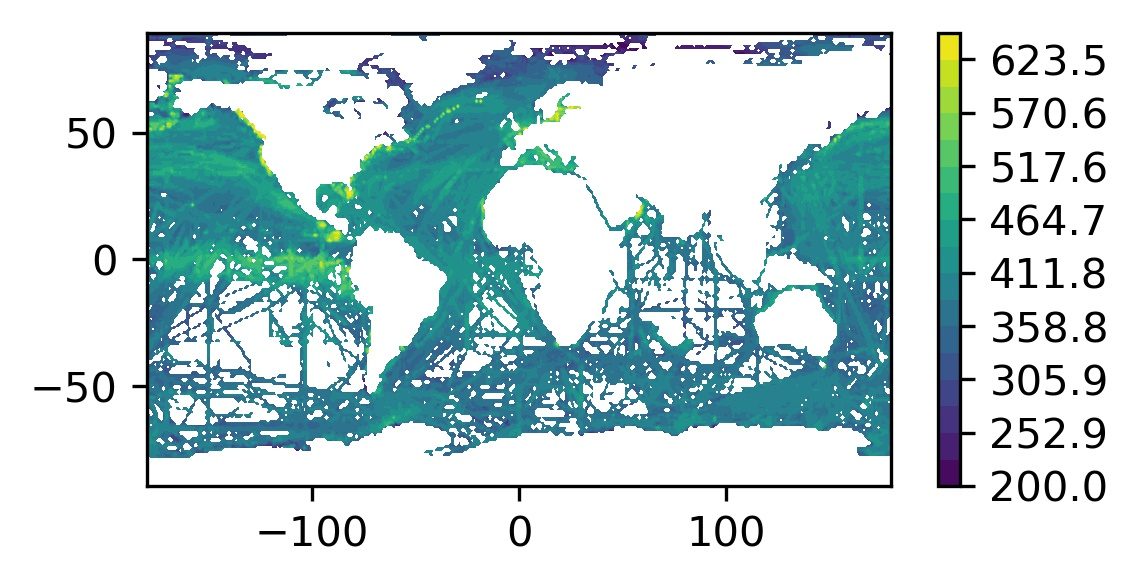

In [68]:
fig = plt.figure(figsize=(4,2))
plt.contourf(xlon,ylat,np.nanmax(pco2,axis=0),levels=np.linspace(200,650,18))
plt.colorbar()

### Examine distribution of pCO2 and remove outliers

In [47]:
pco2_stack = pco2.reshape(-1)

(100, 700)

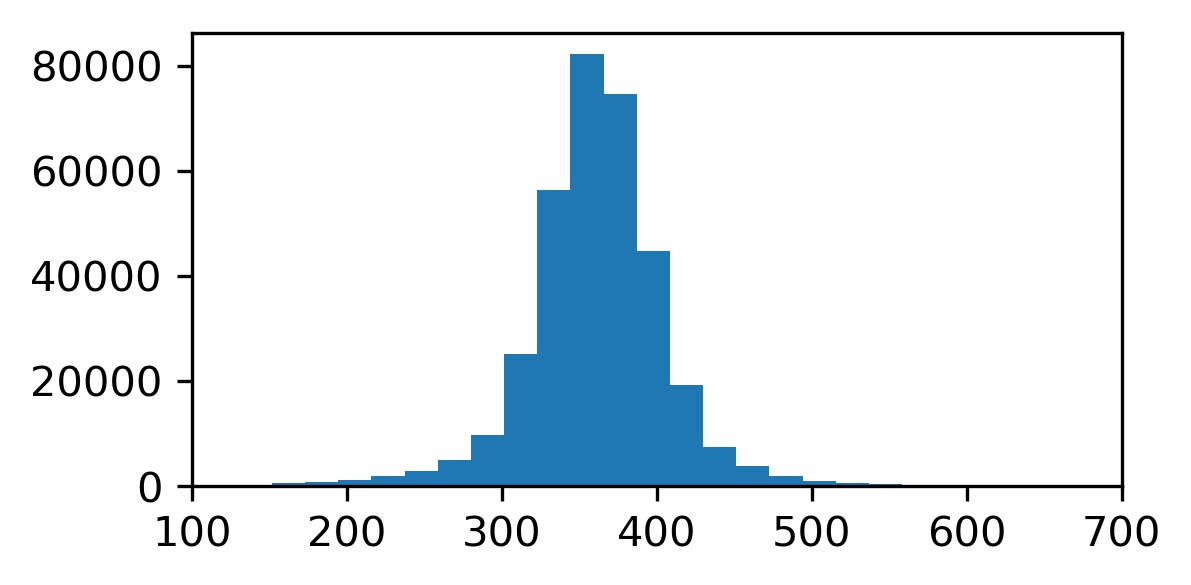

In [56]:
fig = plt.figure(figsize=(4,2))
plt.hist(pco2_stack[~np.isnan(pco2_stack)],200)
plt.xlim(100,700)

In [74]:
# Create an XRARRY DataSet to create an output file to netcdf

socat_out = xr.Dataset(
                        {
                        'pCO2':(["time","ylat","xlon"],pco2),
                        'pCO2_unweight':(["time","ylat","xlon"],pco2_unwt),
                        'socat_mask':(["time","ylat","xlon"],np.where(~np.isnan(pco2),1,np.nan)),
                        'sst':(["time","ylat","xlon"],sst[108:612,:,:]),
                        'sst_unweight':(["time","ylat","xlon"],sst_unweight[108:612,:,:]),
                        'mslp':(["time","ylat","xlon"],mslp[0:504,:,:]),
                        'fco2':(["time","ylat","xlon"],fco2[108:612,:,:]),
                        'fco2_unweight':(["time","ylat","xlon"],fco2_unweight[108:612,:,:])},
                        coords={'time': (['time'],time[108:612]),
                        'ylat': (['ylat'],ylat),
                        'xlon':(['xlon'],xlon)})
        
# Save to netcdf

socat_out.pCO2.attrs['units'] = 'uatm'
socat_out.pCO2.attrs['description'] = 'uses fco2 (weighted), sst (weighted) and MSLP to convert to pCO2 via fCO2_to_pCO2.ipynb'
socat_out.pCO2_unweight.attrs['units'] = 'uatm'
socat_out.pCO2.attrs['description'] = 'uses fco2 (unweighted), sst (unweighted) and MSLP to convert to pCO2 via fCO2_to_pCO2.ipynb'
socat_out.sst.attrs['units'] = 'deg C'
socat_out.sst.attrs['description'] = 'weighted, from /data/artemis/observations/SOCAT/originals/SOCATv2021_tracks_gridded_monthly.nc'
socat_out.sst_unweight.attrs['units'] = 'deg C'
socat_out.sst_unweight.attrs['description'] = 'unweighted, from /data/artemis/observations/SOCAT/originals/SOCATv2021_tracks_gridded_monthly.nc'
socat_out.mslp.attrs['units'] = 'hPa'
socat_out.mslp.attrs['description'] = 'from /data/artemis/observations/ERA5_MSLP/ERA5_MSLP_1x1_1979-2021.nc'
socat_out.fco2.attrs['units'] = 'uatm'
socat_out.fco2.attrs['description'] = 'weighted, from /data/artemis/observations/SOCAT/originals/SOCATv2021_tracks_gridded_monthly.nc'
socat_out.fco2_unweight.attrs['units'] = 'uatm'
socat_out.fco2_unweight.attrs['description'] = 'unweighted, from /data/artemis/observations/SOCAT/originals/SOCATv2021_tracks_gridded_monthly.nc'

socat_out.attrs['created'] = "Val Bennington Jan 21, 2022 using SOCAT_processing.ipynb"
# Save to netcdf
socat_out.to_netcdf('/data/artemis/observations/SOCAT/processed/SOCATv2021_pCO2_gridded_monthly.nc') 

In [75]:
ds = xr.load_dataset('/data/artemis/observations/SOCAT/processed/SOCATv2021_pCO2_gridded_monthly.nc')

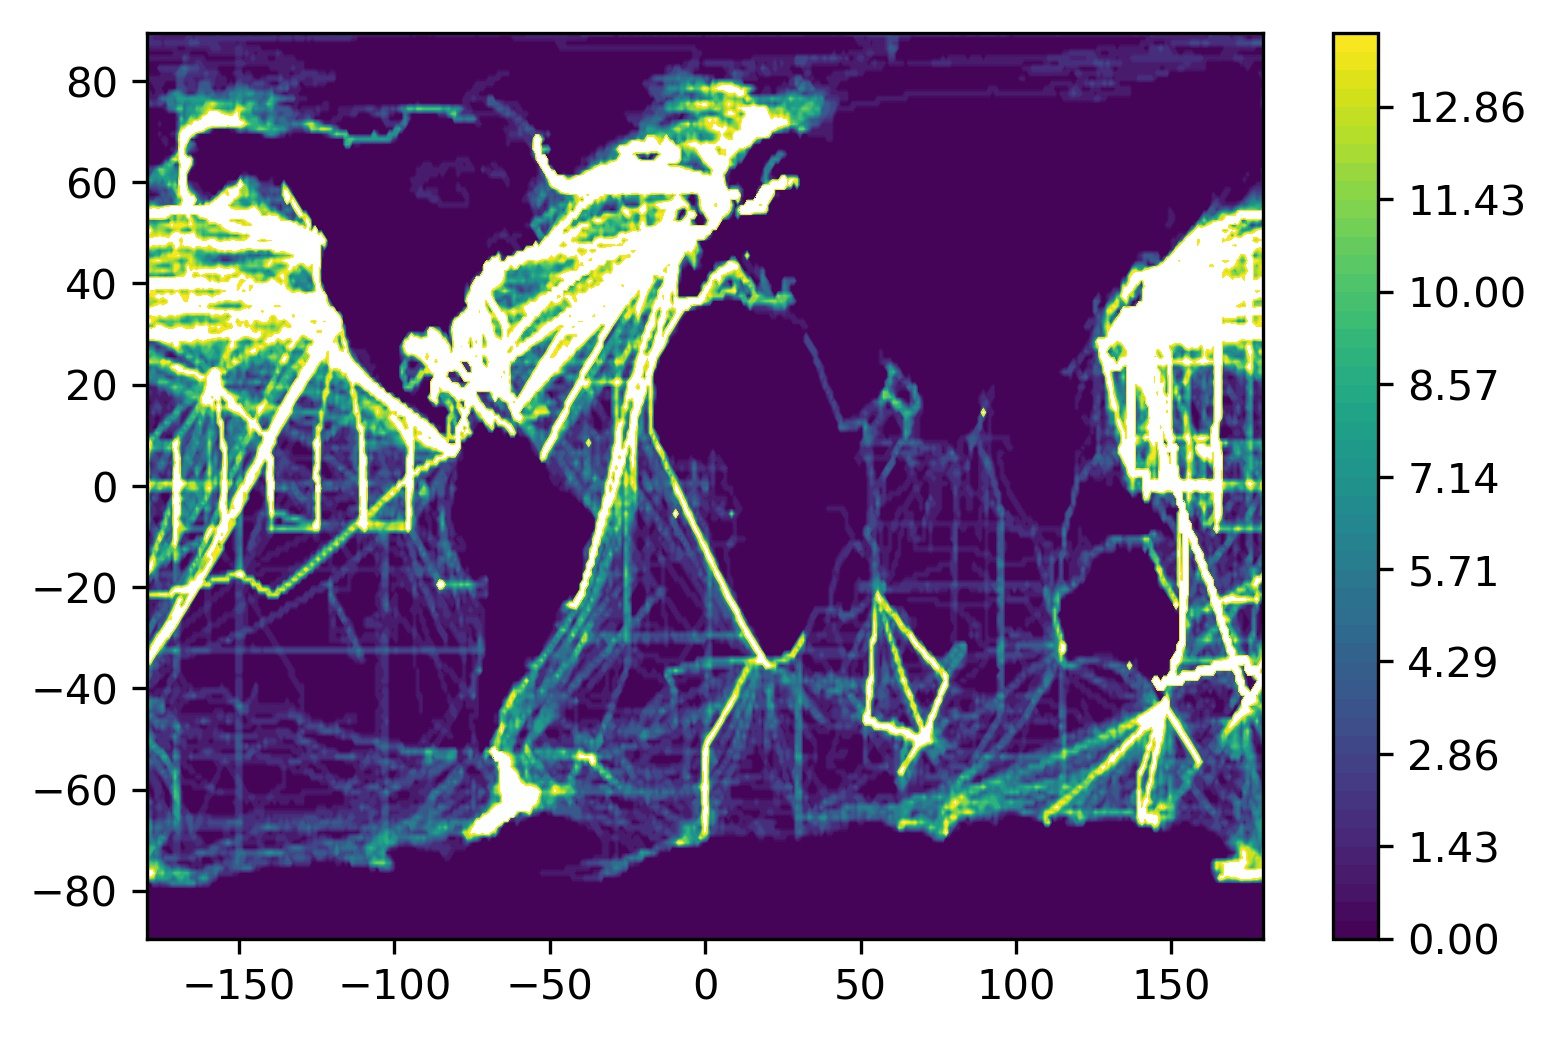

In [78]:
fig = plt.figure()
plt.contourf(ds.xlon,ds.ylat,ds.socat_mask.sum("time"),levels=np.linspace(0,14))
plt.colorbar()